In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, load_coco_data_struct, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
vocab_data, train_data, _  = load_coco_data_struct() # igore actual coco val set
val_data, train_data = train_data.split(0.3) # split further into train/val


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (1004, 304) float64
Word to index <class 'dict'> 1004
Index to word <class 'list'> 1004

Loaded train data.
Captions <class 'numpy.ndarray'> (400135, 17) int32
Image indices <class 'numpy.ndarray'> (400135,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded val data.
Captions <class 'numpy.ndarray'> (195954, 17) int32
Image indices <class 'numpy.ndarray'> (195954,) int32
Image features <class 'numpy.ndarray'> (40504, 4096) float32
Image urls <class 'numpy.ndarray'> (40504,) <U63

Splitting train data with ratio 0.3

Loaded train data.
Captions <class 'numpy.ndarray'> (120040, 17) int32
Image indices <class 'numpy.ndarray'> (120040,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded train data.
Captions <class 'numpy.ndarray'> (280095, 17) int32
Image indices <class 'numpy.ndarray'> (2800

In [4]:
def sample_image(coco_data, batch_size):
    captions, features, urls = coco_data.sample(batch_size)
    show_image_caption(captions, features, urls)

def show_image_by_data_idx(coco_data, data_idx):
    captions, features, urls = coco_data.get(data_idx)
    show_image_caption(captions, features, urls)

def show_image_caption(captions, features, urls):
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = vocab_data.decode_captions(caption)
        plt.title(caption_str)
        plt.show()

def show_image_by_image_idxs(coco_data, img_idxs):
    """
        data indices to find image
    """
    urls = coco_data.get_urls_by_image_index(img_idxs)
    for url in urls:
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()

In [5]:
def group_data_idx_by_image_idx(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_grouped_data_index_to_grouped_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_grouped_data_index_to_grouped_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sampled_image, sampled_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sampled_image.shape) * -1
    return np.concatenate([demo_image, sampled_image], axis=0), np.concatenate([demo_caption, sampled_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)



In [6]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)
    
def create_demo_sampled_batcher(coco_data):
    # create random pairing
    grouped_data_index_by_image_idx = group_data_idx_by_image_idx(coco_data.image_idx)
    grouped_captions_by_image_idx = map_grouped_data_index_to_grouped_captions(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)
    scrambled_grouped_captions_by_image_idx = scramble_image_caption_pairs(coco_data.captions_in_word_idx, grouped_data_index_by_image_idx)

    # merge both, and retain flag
    image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions_by_image_idx)
    image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_grouped_captions_by_image_idx)

    demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
    sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.zeros(image_idx_sampled.shape)))
    return demo_batcher, sample_batcher

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)   
    return image_idx_batch, caption_batch, demo_or_sampled_batch


In [7]:
demo_batcher, sample_batcher = create_demo_sampled_batcher(train_data)
val_demo_batcher, val_sample_batcher = create_demo_sampled_batcher(val_data)

In [8]:
def examine_validation(batch_size=100, to_examine=True):
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(val_demo_batcher, val_sample_batcher, batch_size)
    caption_batch = caption_batch[:,1:]
    loss, reward_per_token, mean_reward = run_validation(sess, discr, val_data, image_idx_batch, caption_batch, demo_or_sampled_batch)
    if to_examine:
        examine(val_data, image_idx_batch, caption_batch, reward_per_token, mean_reward)
    return loss

def assign_reward(sess, discr, coco_data, img_idxs, caption_sentences):
    captions = [c.split() for c in caption_sentences]
    image_feats_test = coco_data.get_image_features(img_idxs)
    caption_test = vocab_data.encode_captions(captions)
    loss, reward_per_token, mean_reward = run_test(sess, discr, image_feats_test, caption_test)
    examine(coco_data, img_idxs, caption_test, reward_per_token, mean_reward)
    return loss, reward_per_token, mean_reward

def run_validation(sess, discr, coco_data, img_idxs, caption_word_idx, demo_or_sampled_batch):
    image_feats = coco_data.get_image_features(img_idxs)
    discr.image_input.pre_feed(image_feats)
    discr.caption_input.pre_feed(caption_word_idx)
    discr.metadata_input.pre_feed(labels=demo_or_sampled_batch)
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
    
def run_test(sess, discr, img_feature_test, caption_test):
    discr.image_input.pre_feed(img_feature_test)
    discr.caption_input.pre_feed(caption_test)
    discr.metadata_input.pre_feed(labels=np.ones(img_feature_test.shape[0]))
    loss, reward_per_token, mean_reward = discr.test(sess)
    return loss, reward_per_token, mean_reward
                           
def examine(coco_data, chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img_idx, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        show_image_by_image_idxs(coco_data, [img_idx])
        decoded = vocab_data.decode_captions(cap).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(coco_data, demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(coco_data, chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 0 )[0], num_to_examine)
    examine_sample(chosen)

def random_sentence():
    word_idxs = np.random.choice(np.arange(vocab_data.START_ID + 1, vocab_data.vocab_dim), np.random.randint(8,12))
    return vocab_data.decode_captions(np.array([word_idxs]))


## Model

In [9]:
import tensorflow as tf
from discriminator import CaptionInput, ImageInput, MetadataInput, Discriminator, LstmScalarRewardStrategy
import layer_utils

In [10]:
tf.reset_default_graph()
caption_input = CaptionInput(word_embedding_init=vocab_data.embedding(),null_id=vocab_data.NULL_ID)
image_input = ImageInput(image_feature_dim=train_data.image_feature_dim)
metadata_input = MetadataInput()
reward_config = LstmScalarRewardStrategy.RewardConfig(
    reward_scalar_transformer = lambda x: tf.nn.tanh(layer_utils.affine_transform(x, 1, 'hidden_to_reward')),
    take_difference = False
)
discr = Discriminator(caption_input, image_input, metadata_input, reward_config=reward_config, hidden_dim=512)

## Training

In [11]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [12]:
iter_num = 400
batch_size = 1000

train_losses = []
val_losses = []
for i in range(iter_num):
    
    image_idx_batch, caption_batch, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    caption_batch = caption_batch[:,1::]
    image_feats_batch = train_data.get_image_features(image_idx_batch)
    
    discr.caption_input.pre_feed(caption_word_ids=caption_batch)
    discr.image_input.pre_feed(image_features=image_feats_batch)
    discr.metadata_input.pre_feed(demo_or_sampled_batch)
    loss, m, me = discr.train(sess)
        
    train_losses.append(loss)
    if i % 20 ==0:
        print("iter {}, loss: {}".format(i, loss))
    
    if i % 5 ==0:
        val_loss = examine_validation(batch_size, to_examine=False)
        val_losses.append(val_loss)
    else:
        val_losses.append(val_losses[-1])
        


iter 0, loss: -0.0017634453251957893
iter 20, loss: -0.10533622652292252
iter 40, loss: -0.1922050416469574
iter 60, loss: -0.3560493290424347
iter 80, loss: -0.42097577452659607
iter 100, loss: -0.45877575874328613
iter 120, loss: -0.48508110642433167
iter 140, loss: -0.5072333216667175
iter 160, loss: -0.499901682138443
iter 180, loss: -0.5193964838981628
iter 200, loss: -0.5489415526390076
iter 220, loss: -0.5361775159835815
iter 240, loss: -0.5381593108177185
iter 260, loss: -0.5655344128608704
iter 280, loss: -0.5695767998695374
iter 300, loss: -0.5657832622528076
iter 320, loss: -0.5814746618270874
iter 340, loss: -0.5844619274139404
iter 360, loss: -0.6056451797485352
iter 380, loss: -0.577669084072113
iter 400, loss: -0.580441415309906
iter 420, loss: -0.5970194935798645
iter 440, loss: -0.5838512182235718
iter 460, loss: -0.5956921577453613
iter 480, loss: -0.5969881415367126
iter 500, loss: -0.5772830843925476
iter 520, loss: -0.6219717860221863
iter 540, loss: -0.59528177976

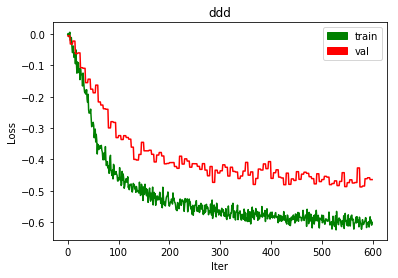

In [20]:
import matplotlib.patches as mpatches

plt.plot(np.arange(0, len(train_losses)), train_losses, 'g', val_losses, 'r')
train_loss_patch = mpatches.Patch(color='g', label='train')
val_loss_patch = mpatches.Patch(color='r', label='val')
plt.legend(handles=[train_loss_patch, val_loss_patch])
plt.ylabel('Loss')
plt.xlabel('Iter')
plt.title('tanh, no-diff-affine-reward')
plt.show()

DEMO RESULTS
[435  37 705 791]
Avg reward:  0.830355


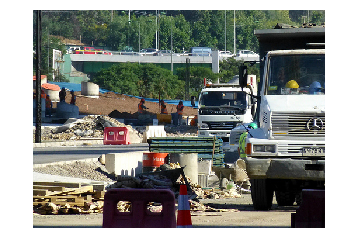

a               0.9347594976425171
bunch           0.31836071610450745
of              -0.11921755224466324
trucks          0.9999975562095642
and             1.0
items           1.0
at              1.0
a               1.0
construction    1.0
<UNK>           1.0
<END>           1.0
- - - -
Avg reward:  0.911957


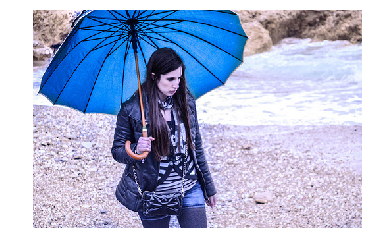

a               -0.13458704948425293
woman           0.998026430606842
with            0.9945513606071472
a               0.9984122514724731
blue            0.9990798234939575
umbrella        0.9999545216560364
walks           0.9999996423721313
<UNK>           1.0
along           1.0
the             1.0
rocky           1.0
shore           1.0
<END>           1.0
- - - -
Avg reward:  0.721778


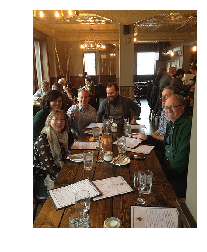

people          -0.9417542815208435
at              0.9485877752304077
a               0.9225807785987854
long            0.6868634819984436
wooden          0.6017687320709229
table           0.9997410774230957
in              0.9999939203262329
a               0.9999995827674866
<UNK>           0.9999996423721313
<END>           1.0
- - - -
Avg reward:  0.818364


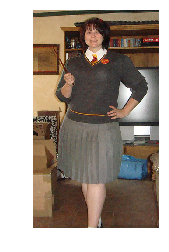

a               -0.9979780316352844
woman           0.9999839663505554
standing        1.0
in              1.0
a               1.0
living          1.0
room            1.0
holding         1.0
a               1.0
<UNK>           1.0
<END>           1.0
- - - -


SAMPLED RESULTS
[1338 1976 1372 1405]
Avg reward:  -0.99653


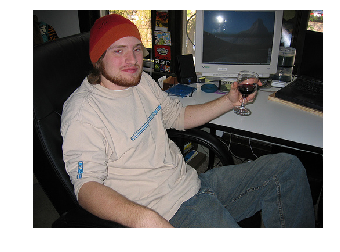

a               -0.9479545950889587
decorative      -0.9999920725822449
carrot          -1.0
with            -1.0
a               -1.0
<UNK>           -1.0
<UNK>           -1.0
cut             -1.0
on              -1.0
top             -1.0
<UNK>           -1.0
a               -1.0
palm            -1.0
tree            -1.0
<END>           -1.0
- - - -
Avg reward:  0.582685


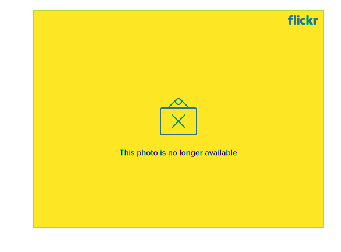

<UNK>           0.9159722328186035
elephants       -0.6161588430404663
<UNK>           0.7389575839042664
passengers      0.9925486445426941
across          0.9852298498153687
a               0.9940487742424011
<UNK>           0.9980549216270447
river           0.7828483581542969
<END>           -0.547336220741272
- - - -
Avg reward:  0.886101


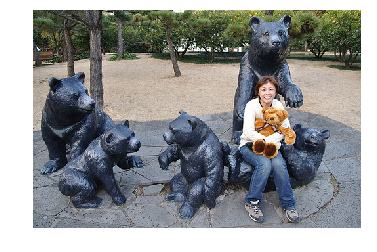

a               -0.4752422869205475
dog             0.9946754574775696
hanging         0.9998824000358582
out             0.9999999403953552
of              1.0
the             1.0
back            1.0
window          1.0
of              1.0
a               1.0
white           1.0
truck           1.0
<END>           1.0
- - - -
Avg reward:  -0.959571


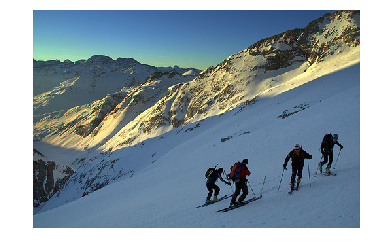

a               -0.4339931905269623
pizza           -1.0
pie             -1.0
covered         -1.0
with            -1.0
<UNK>           -1.0
tomatoes        -1.0
sliced          -1.0
meat            -1.0
cheese          -1.0
and             -1.0
other           -1.0
<UNK>           -1.0
<END>           -1.0
- - - -


In [14]:
examine_batch_results(train_data, demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

Avg reward:  0.921757


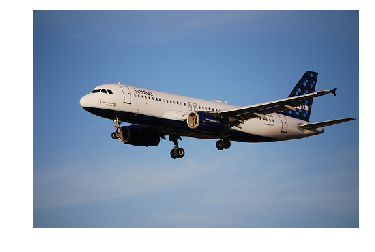

an              0.343636155128479
airplane        0.9577133655548096
<UNK>           0.9945870637893677
through         0.9999848008155823
a               0.9999908208847046
clear           0.9999468922615051
blue            0.9999558925628662
sky             1.0
<END>           1.0
- - - -
Avg reward:  0.998671


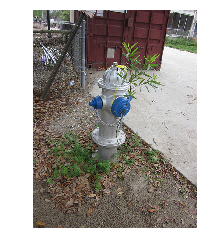

a               0.9820226430892944
blue            0.9993721842765808
and             0.9999939203262329
white           1.0
fire            0.9999999403953552
hydrant         1.0
in              1.0
front           1.0
of              1.0
a               1.0
<UNK>           1.0
<UNK>           1.0
fence           1.0
<END>           1.0
- - - -
Avg reward:  0.880486


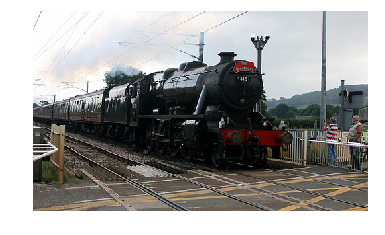

a               -0.19496716558933258
train           0.9998290538787842
traveling       0.9999998211860657
down            1.0
train           1.0
tracks          1.0
next            1.0
to              1.0
people          1.0
<END>           1.0
- - - -
Avg reward:  0.91369


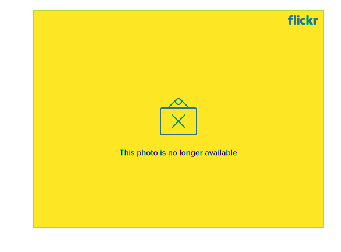

a               0.1374691277742386
mirror          0.9995060563087463
a               0.9999307990074158
sink            0.9999985694885254
some            0.9999998807907104
pictures        0.9999999403953552
and             1.0
a               1.0
towel           1.0
<END>           1.0
- - - -
Avg reward:  0.985263


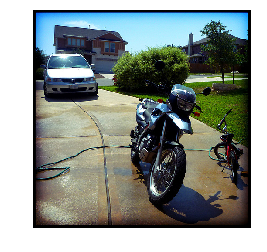

a               0.9063268899917603
motorcycle      0.9633939862251282
parked          0.9976451992988586
next            0.999998152256012
to              1.0
a               1.0
<UNK>           1.0
bike            1.0
<END>           1.0
- - - -
Avg reward:  -0.154208


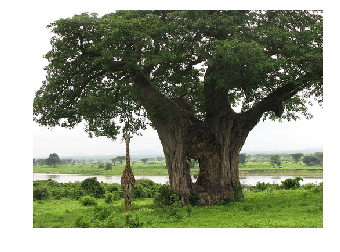

a               0.9946233630180359
close           0.943091094493866
up              0.7049083709716797
of              0.751213550567627
a               0.2739904820919037
dog             -0.3650963008403778
laying          -0.9995975494384766
on              -0.9994234442710876
a               -0.9999973177909851
bench           -0.9999982118606567
<END>           -0.9999999403953552
- - - -
Avg reward:  -0.811909


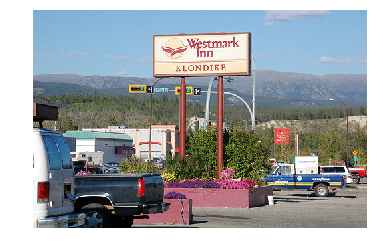

a               0.9868897795677185
man             -0.9027730822563171
with            -0.7867063283920288
a               -0.7349694967269897
remote          -0.8508775234222412
<UNK>           -0.7144900560379028
at              -0.992287278175354
a               -0.9954027533531189
television      -0.9999300837516785
screen          -0.9999978542327881
sitting         -1.0
beside          -1.0000001192092896
an              -1.0
open            -1.0
laptop          -1.0
<END>           -1.0
- - - -
Avg reward:  -0.516787


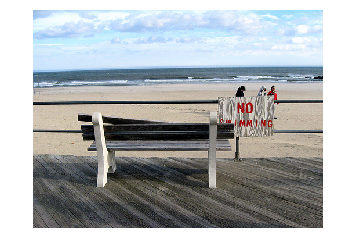

a               0.9950476288795471
man             0.8751556873321533
with            0.9283533096313477
cake            -0.9999995827674866
on              -0.9999985098838806
his             -1.0
face            -1.0
and             -1.0
others          -1.0
eating          -1.0
cake            -1.0
<END>           -1.0
- - - -
Avg reward:  0.998184


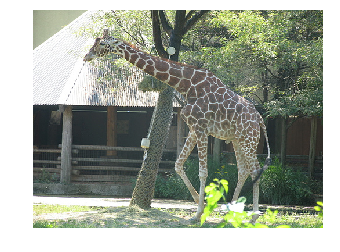

a               0.9750540852546692
bird            0.9995254278182983
stands          0.9999998807907104
on              1.0
a               1.0
<UNK>           1.0
branch          1.0
as              1.0
it              1.0
<UNK>           1.0
into            1.0
the             1.0
distance        1.0
<END>           1.0
- - - -
Avg reward:  -0.786264


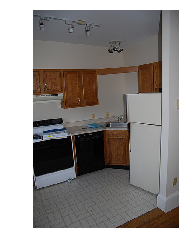

an              0.5629955530166626
<UNK>           -0.031322915107011795
bird            -0.9670672416687012
on              -0.9997930526733398
the             -0.9999815225601196
ground          -0.999994695186615
getting         -1.0
ready           -1.0
to              -1.0
fly             -1.0
away            -1.0
<END>           -1.0
- - - -


-0.597085

In [18]:
examine_validation(5, to_examine=True)


#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

#### Removing first start token makes good difference. To redo experiments. Initial results after 100 iter/ 1000 batch size per each demo/sample

Avg reward:  0.746995


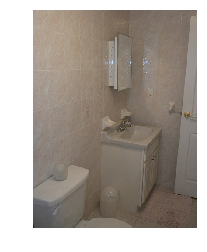

counter         0.6695895195007324
number          -0.9861630797386169
cabinet         0.9879055023193359
fenced          0.8631497621536255
full            0.958189070224762
painted         0.9774340391159058
sticking        0.9998685717582703
in              0.9999980330467224
tables          0.9999979734420776
sauce           0.9999849796295166
- - - -
Avg reward:  -0.738149


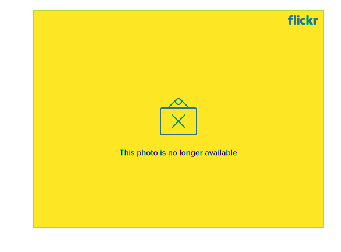

rides           0.987975537776947
fish            -0.6525902152061462
painting        -0.9142637252807617
colorful        -0.8573810458183289
soccer          -0.9999409914016724
doors           -0.9898799657821655
next            -0.9559770822525024
he              -0.9999983310699463
farm            -0.99942946434021
chocolate       -1.0
- - - -
Avg reward:  0.725681


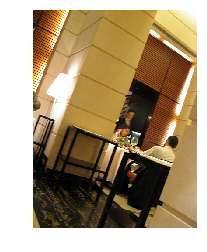

horses          0.06487256288528442
persons         0.6728802919387817
coat            0.5174579620361328
station         0.9944340586662292
eat             0.94983971118927
someone         0.9981911778450012
holding         0.9078738689422607
before          0.699895977973938
- - - -
Avg reward:  -0.732446


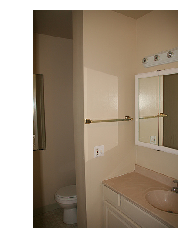

apple           0.7315065860748291
moving          -0.8538070917129517
metal           -0.9876986742019653
someone         -0.9986679553985596
rack            -0.6428610682487488
pots            -0.30553603172302246
tracks          -0.9998417496681213
foods           -0.999994695186615
picnic          -1.0
spoon           -1.0
striped         -1.0
- - - -
Avg reward:  -0.806264


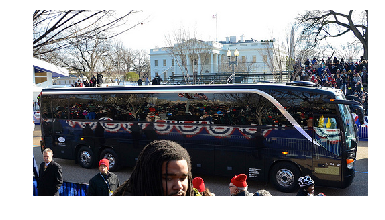

bread           0.5796038508415222
skiing          -0.8722710013389587
slices          -0.9999260306358337
players         -1.0
near            -0.9999998211860657
clocks          -0.9807189106941223
bun             -0.999986469745636
city            -0.9830756187438965
plate           -1.0
- - - -


In [17]:

img_idx = np.random.choice(val_data.image_idx, 5)
captions = [random_sentence()[0] for _ in range(len(img_idx))]
_ = assign_reward(sess, discr, val_data, img_idx, captions)